In [1]:
#!pip3 install albumentations

In [2]:
#!pip3 install qtconsole
%qtconsole #for editing variables on the fly without creating cells!! isnt that awesome?

In [3]:
from keras.layers import Input
from keras.models import Model,load_model,save_model
from keras.layers import Activation,BatchNormalization
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense

import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

import albumentations as A

Using TensorFlow backend.


In [4]:
#read template image
img = cv2.imread("template.jpg")
rows, cols, ch = img.shape

width=128
height=128
dim = (width, height)
# resize image
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 

In [5]:
def getdata(img,count,disp=False):
    #randomly transform the template image to generate sample data
    #need to add a new function that generates data by registering real -
    #input images with template and thus generating transform matrix
    xtrain=[]
    ytrain=[]
    d=20
    
    pts1 = np.float32([[0, 0], [width, 0], [width, height]])

    '''
    cv2.circle(img, tuple(pts1[0]), 5, (0, 0, 255), -1)
    cv2.circle(img, tuple(pts1[1]), 5, (0, 0, 255), -1)
    cv2.circle(img, tuple(pts1[2]), 5, (0, 0, 255), -1)
    cv2.imshow("Image", img)
    '''
    aug = A.Compose([
    A.RandomBrightnessContrast(p=.5),    
    A.RandomGamma(p=.5),    
    #A.CLAHE(p=1), 
    A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=50, val_shift_limit=50, p=.5),
    
    ], p=.5)
    
    for i in range(count):
        

        d0 = random.sample(range(-d, d), 2)
        d1 = random.sample(range(-d, d), 2)
        d2 = random.sample(range(-d, d), 2)
        #import pdb;pdb.set_trace()

        pts2 = np.float32([pts1[0]+d0, pts1[1]+d1, pts1[2]+d2])

        matrix = cv2.getAffineTransform(pts1, pts2)
        result = cv2.warpAffine(img, matrix, (width, height))
        #augmentations
        result = aug(image=result)['image']
        
        #import pdb;pdb.set_trace()
        matrix = cv2.invertAffineTransform(matrix)
        matrix = matrix.flatten()
        
        xtrain.append(result)
        ytrain.append(matrix)
        
        if disp==True:
            cv2.imshow("Affine transformation", result)
            cv2.waitKey(100)
    cv2.destroyAllWindows()
    xtrain = np.array(xtrain, dtype=np.float32)
    ytrain = np.array(ytrain, dtype=np.float32)
    return(xtrain/255.0, ytrain)

In [6]:
batch_size = 64

In [7]:
xtrain, ytrain = getdata(img,batch_size*1, disp=True)

In [8]:
xval, yval = getdata(img,batch_size*3, disp=True)

In [9]:
#xtest, ytest = getdata(img,batch_size*3)

In [10]:
xtrain.shape

(64, 128, 128, 3)

In [11]:
ytrain.shape

(64, 6)

In [12]:
#from utils1 import get_initial_weights
#from layers import BilinearInterpolation

def localizer(input_shape=(width, height, 3), sampling_size=(30, 30), num_classes=10):
    image = Input(shape=input_shape)
    locnet = Conv2D(20, (5, 5))(image)
    locnet = BatchNormalization()(locnet)
    locnet = MaxPool2D(pool_size=(2, 2))(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Conv2D(20, (5, 5))(locnet)
    locnet = BatchNormalization()(locnet)
    locnet = MaxPool2D(pool_size=(2, 2))(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Conv2D(40, (5, 5))(locnet)
    locnet = BatchNormalization()(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    #weights = get_initial_weights(50)
    theta = Dense(6)(locnet)
    return Model(inputs=image, outputs=theta)

    

In [13]:
if True:
    model = load_model('weight.h5')
else:
    model = localizer()
    model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 124, 124, 20)      1520      
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 124, 20)      80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 20)        0         
_________________________________________________________________
activation_5 (Activation)    (None, 62, 62, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 58, 58, 20)        10020     
_________________________________________________________________
batch_normalization_5 (Batch (None, 58, 58, 20)        80        
__________

In [14]:
def transform(img,matrix):
    #assuming input img is normalized, else remove 255s
    rows, cols, ch = img.shape
    #import pdb;pdb.set_trace()
    img = img*255
    img= img.astype(np.uint8)
    theta = matrix.reshape(2,3)
    img2 = cv2.warpAffine(img, theta, (cols, rows))
    img2= img2.astype(np.float32)
    img2 = img2/255.0
    return img2

In [15]:
def transform_plot(x_batch,y_batch, matrices):
    fig = plt.figure()
    plt.clf()
    for image_arg in range(3):
        #import pdb;pdb.set_trace()
        
        img = x_batch[image_arg]
        M2 = matrices[image_arg]
        M=y_batch[image_arg]
        
        img2 = transform(img,M2)
        
        print('    M:',[ '%.2f' % elem for elem in M ])
        print('   M2:',[ '%.2f' % elem for elem in M2 ])
        plt.subplot(3, 2, image_arg*2 + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.subplot(3, 2, image_arg*2 + 2)
        plt.imshow(img2)
        plt.axis('off')
    fig.canvas.draw()
    plt.show()

Epoch: 0 / 10 loss:  0.0130008925

Epoch: 1 / 10 loss:  0.015392156

Epoch: 2 / 10 loss:  0.017644245

Epoch: 3 / 10 loss:  0.022504874

Epoch: 4 / 10 loss:  0.009467186

Epoch: 5 / 10 loss:  0.015685622

Epoch: 6 / 10 loss:  0.032333788

Epoch: 7 / 10 loss:  0.031639524

Epoch: 8 / 10 loss:  0.02885966

Epoch: 9 / 10 loss:  0.016590407

    M: ['1.00', '-0.27', '15.71', '-0.03', '1.13', '0.71']
   M2: ['1.02', '-0.25', '15.83', '-0.04', '1.13', '0.44']
    M: ['0.96', '0.01', '-9.59', '0.15', '0.99', '-4.50']
   M2: ['0.97', '0.00', '-9.72', '0.15', '0.96', '-4.86']
    M: ['0.83', '0.01', '8.18', '0.13', '0.99', '-11.48']
   M2: ['0.89', '0.02', '8.37', '0.11', '1.00', '-11.71']


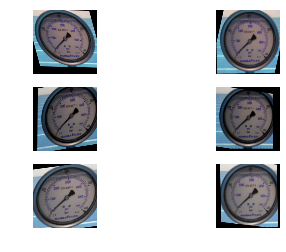

In [16]:
num_epochs = 10
loss=[]
#val_score1=20
val_score1 =np.load('val_score1.npy')
for epoch_arg in range(num_epochs):
    xtrain, ytrain = getdata(img,batch_size*16)
    for batch_arg in range(xtrain.shape[0]//batch_size):
        arg_0 = batch_arg * batch_size
        arg_1 = (batch_arg + 1) * batch_size
        x_batch, y_batch = xtrain[arg_0:arg_1], ytrain[arg_0:arg_1]
        
        #import pdb;pdb.set_trace()
        loss = model.train_on_batch(x_batch, y_batch)
    print('Epoch:',epoch_arg, '/',num_epochs, 'loss: ',loss)
    
    if (epoch_arg % 10 == 0) and (epoch_arg>0):
        val_score = model.evaluate(xval, yval, verbose=1)
        print('validation loss :', val_score)
        if val_score<val_score1:
            print('validation loss reduced, saving weights',val_score1, val_score)
            val_score1=val_score
            np.save('val_score1.npy',val_score1)
            model.save('weight.h5')
        
            matrices = model.predict_on_batch(x_batch)
            transform_plot(x_batch,y_batch, matrices)
            print('-' * 40)
    print()


model = load_model('weight.h5')
matrices = model.predict_on_batch(xval)
transform_plot(xval,yval, matrices)